In [1]:

import random
import os
import glob
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras 
import gzip
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

os.chdir('../functions/')
from models import get_class_weight, upsample, preprocessor, plot_confusion_matrix, compile_image_model, \
                    CNN_model,label_dict, revlabel_dict, recreate_labels



# label_dict = {0: 'objects', 1: 'hole', 2: 'oil spot', 3: 'thread error'},
# revlabel_dict = {'objects': 0, 'hole': 1, 'oil spot': 2, 'thread error': 3}

In [2]:
ls -lr ../

total 1184
drwxr-xr-x   3 willtong  staff      96 Jul 31 14:50 tilda_defect_classific/
-rw-r--r--   1 willtong  staff  268760 Jul 31 16:19 tilda-cls-multi.zip
drwxr-xr-x   3 willtong  staff      96 Jul 31 14:50 tests/
-rw-r--r--@  1 willtong  staff     564 Aug  7 16:55 pyproject.toml
-rw-r--r--@  1 willtong  staff  327750 Aug  7 16:55 poetry.lock
drwxr-xr-x  10 willtong  staff     320 Aug  1 10:30 notebooks/
drwxr-xr-x  16 willtong  staff     512 Aug  8 01:36 notebook_CNN/
drwxr-xr-x   6 willtong  staff     192 Aug  7 23:06 functions/
drwxr-xr-x   5 willtong  staff     160 Aug  6 21:04 data/
-rw-r--r--   1 willtong  staff       0 Jul 31 14:48 README.md


In [28]:

DATA_DIR = "../../data/"
large_labels = ["thread error", "objects", "oil spot", "hole"]#, "good"]
# label_scale = [1, 1, 1, 1, 1]

#walk all the files and add them to this
all_files = [filename for filename in glob.glob(DATA_DIR + "//*//*") if 'mono' in filename]
all_files = [filename for filename in all_files if 'augment' not in filename and 'tilda' not in filename 
             and filename.split("/")[3] in large_labels]
all_labels = [filename.split("/")[-2] for filename in all_files]
all_labels_numerical = [revlabel_dict[filename.split("/")[-2]] for filename in all_files]

# #shuffle
# random.shuffle(all_files)
# #get class names

In [29]:
data_frame = pd.DataFrame()
data_frame["Label"] = all_labels
data_frame["Path"] = all_files
data_frame

,Label,Path
0,oil spot,../../data/oil spot/197_patch6-2mono.png
1,oil spot,../../data/oil spot/083_patch1-5mono.png
2,oil spot,../../data/oil spot/092_patch6-5mono.png
3,oil spot,../../data/oil spot/250_patch5-7mono.png
4,oil spot,../../data/oil spot/081_patch1-2mono.png
...,...,...
2425,hole,../../data/hole/221_patch3-3mono.png
2426,hole,../../data/hole/030_patch2-6mono.png
2427,hole,../../data/hole/236_patch3-7mono.png
2428,hole,../../data/hole/227_patch4-7mono.png


In [30]:
#first see one of the images
# for trail in range(100):
#     random_sample_number = np.random.randint(data_frame.shape[0])
#     if data_frame.iloc[random_sample_number]["Label"] == 'oil spot':
#         print(random_sample_number)
#         test_arr = plt.imread(data_frame.iloc[random_sample_number]["Path"])
#         print(test_arr.min(), test_arr.max())
#         print(data_frame.iloc[random_sample_number]["Label"])
#         plt.imshow(test_arr, cmap= 'Greys')
#         plt.show()

<Axes: xlabel='Label', ylabel='count'>

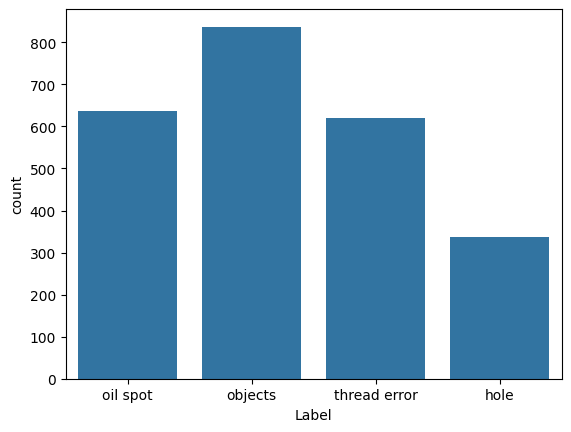

In [31]:
sns.countplot(x = data_frame["Label"]) 

In [32]:
#perform train_test_split
#label encode
# labeller = dict(zip([i for i in balance_df["Label"].unique()], [i for i in range(len(balance_df["Label"].unique()))]))

# rev_labeller = dict(zip([i for i in range(len(balance_df["Label"].unique()))],[i for i in balance_df["Label"].unique()]))
# features = balance_df["Links"]
# label = balance_df["Label"].map(labeller)

features_train, features_eval, labels_train, labels_eval = train_test_split(all_files, all_labels_numerical, stratify=all_labels_numerical, test_size = 0.2, random_state = 11)
features_test, features_eval, labels_test, labels_eval = train_test_split(features_eval, labels_eval, stratify=labels_eval, test_size = 0.5, random_state = 12)


features_train, labels_train, label_upsample_factors =\
    upsample(all_files, revlabel_dict, label_dict, target_samples_per_class = 4000)
features_eval, labels_eval, label_upsample_factors =\
    upsample(all_files, revlabel_dict, label_dict, target_samples_per_class = 500)
# features_test, labels_test, label_upsample_factors =\
#     upsample(all_files, revlabel_dict, label_dict, target_samples_per_class = 2000)

In [33]:
pd.DataFrame(labels_train).value_counts(), pd.DataFrame(labels_eval).value_counts(), pd.DataFrame(labels_test).value_counts()

(0
 0    4185
 1    4044
 2    3816
 3    3720
 Name: count, dtype: int64,
 0
 0    837
 2    636
 3    620
 1    337
 Name: count, dtype: int64,
 0
 0    84
 2    63
 3    62
 1    34
 Name: count, dtype: int64)

In [34]:
class_weights = get_class_weight(labels_train)
class_weights

0.00023894862604540023
0.0002472799208704253
0.0002620545073375262
0.00026881720430107527


{0: 0.00023894862604540023,
 1: 0.0002472799208704253,
 2: 0.0002620545073375262,
 3: 0.00026881720430107527}

In [35]:
pd.DataFrame(labels_train).value_counts(), pd.DataFrame(labels_eval).value_counts()

(0
 0    4185
 1    4044
 2    3816
 3    3720
 Name: count, dtype: int64,
 0
 0    837
 2    636
 3    620
 1    337
 Name: count, dtype: int64)

In [36]:

labels_train = recreate_labels(features_train, revlabel_dict)
labels_eval = recreate_labels(features_eval, revlabel_dict)
labels_test= recreate_labels(features_test, revlabel_dict)

In [37]:
#define dataset objects and preprocessors
features_train_dataset = tf.data.Dataset.from_tensor_slices(features_train)
features_eval_dataset = tf.data.Dataset.from_tensor_slices(features_eval)
features_test_dataset = tf.data.Dataset.from_tensor_slices(features_test)
labels_train_dataset = tf.data.Dataset.from_tensor_slices(labels_train)
labels_eval_dataset = tf.data.Dataset.from_tensor_slices(labels_eval)
labels_test_dataset = tf.data.Dataset.from_tensor_slices(labels_test)


features_train_dataset = features_train_dataset.map(preprocessor)
features_eval_dataset = features_eval_dataset.map(preprocessor)
features_test_dataset = features_test_dataset.map(preprocessor)

train_set = tf.data.Dataset.zip((features_train_dataset, labels_train_dataset))
eval_set = tf.data.Dataset.zip((features_eval_dataset, labels_eval_dataset))
test_set = tf.data.Dataset.zip((features_test_dataset, labels_test_dataset))

train_set = train_set.batch(128).shuffle(128).prefetch(128)
eval_set = eval_set.batch(128).prefetch(128)
test_set = test_set.batch(128).prefetch(128)

In [38]:
np.unique(labels_train, return_counts=True), \
np.unique(labels_eval, return_counts=True), \
np.unique(labels_test, return_counts=True), \
class_weights

((array([0, 1, 2, 3]), array([4185, 4044, 3816, 3720])),
 (array([0, 1, 2, 3]), array([837, 337, 636, 620])),
 (array([0, 1, 2, 3]), array([84, 34, 63, 62])),
 {0: 0.00023894862604540023,
  1: 0.0002472799208704253,
  2: 0.0002620545073375262,
  3: 0.00026881720430107527})

In [ ]:
## dim = 3
conv_factor = 1
image_model = CNN_model(dim, 0.1, patience = 100, conv_factor = conv_factor, lr = 0.00001, num_classes = 4)
history, image_learner = image_model.fit( train_set, eval_set, label_dict, class_weights=class_weights)


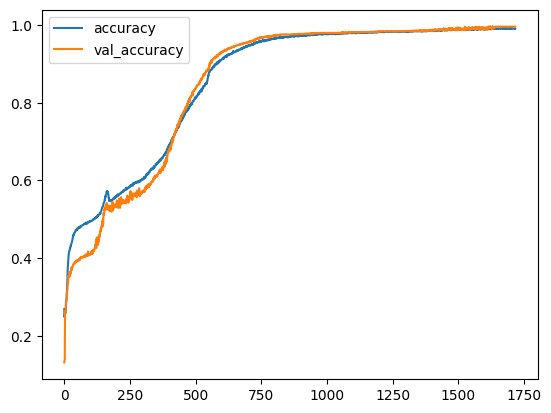

Finished fitting.  Predicting X...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Finished predicting X.
[[15  0  0  0]
 [ 0 47  0  0]
 [ 0  0 36  0]
 [ 0  0  0 30]]


2024-08-08 09:02:58.656298: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


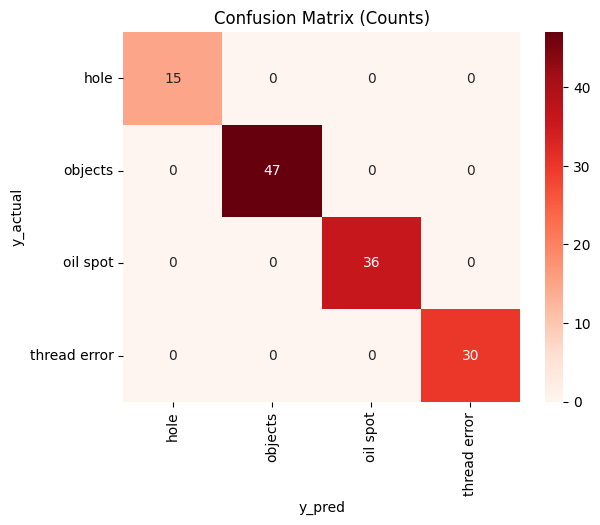

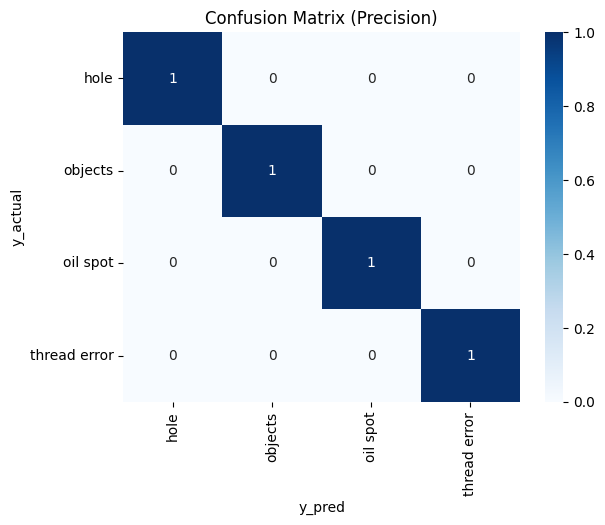

In [40]:
metric = 'accuracy'
plt.plot(history.history[metric], label = metric)
metric = 'val_accuracy'
plt.plot(history.history[metric], label = metric)
plt.legend()
plt.show()
y_predict, y_prob = image_model.predict(test_set)

In [41]:

with gzip.open(f"../data/models/y_prob_{str(dim)}_{str(conv_factor)}_long.pckl", 'wb') as f:
    pickle.dump(y_prob, f)
with gzip.open(f"../data/models/image_learner_{str(dim)}_{str(conv_factor)}_long.pckl", 'wb') as f:
    pickle.dump(image_learner, f)
with gzip.open(f"../data/models/history_{str(dim)}_{str(conv_factor)}_long.pckl", 'wb') as f:
    pickle.dump(history, f)

In [20]:

dim = 20
conv_factor = 1
with gzip.open(f"../data/models/y_prob_{str(dim)}_{str(conv_factor)}_long.pckl", 'rb') as f:
    y_prob = pickle.load(f)
with gzip.open(f"../data/models/image_learner_{str(dim)}_{str(conv_factor)}_long.pckl", 'rb') as f:
    image_learner = pickle.load(f)
with gzip.open(f"../data/models/history_{str(dim)}_{str(conv_factor)}_long.pckl", 'rb') as f:
    history = pickle.load(f)

In [42]:
image_learner.optimizer.learning_rate.numpy()

1e-05

In [43]:
last_layer = image_learner.layers[-1]

In [44]:
last_layer.units

4

In [48]:
conv2d_16_layer = image_learner.layers[0]
print(conv2d_16_layer.kernel.shape)

(3, 3, 3, 16)


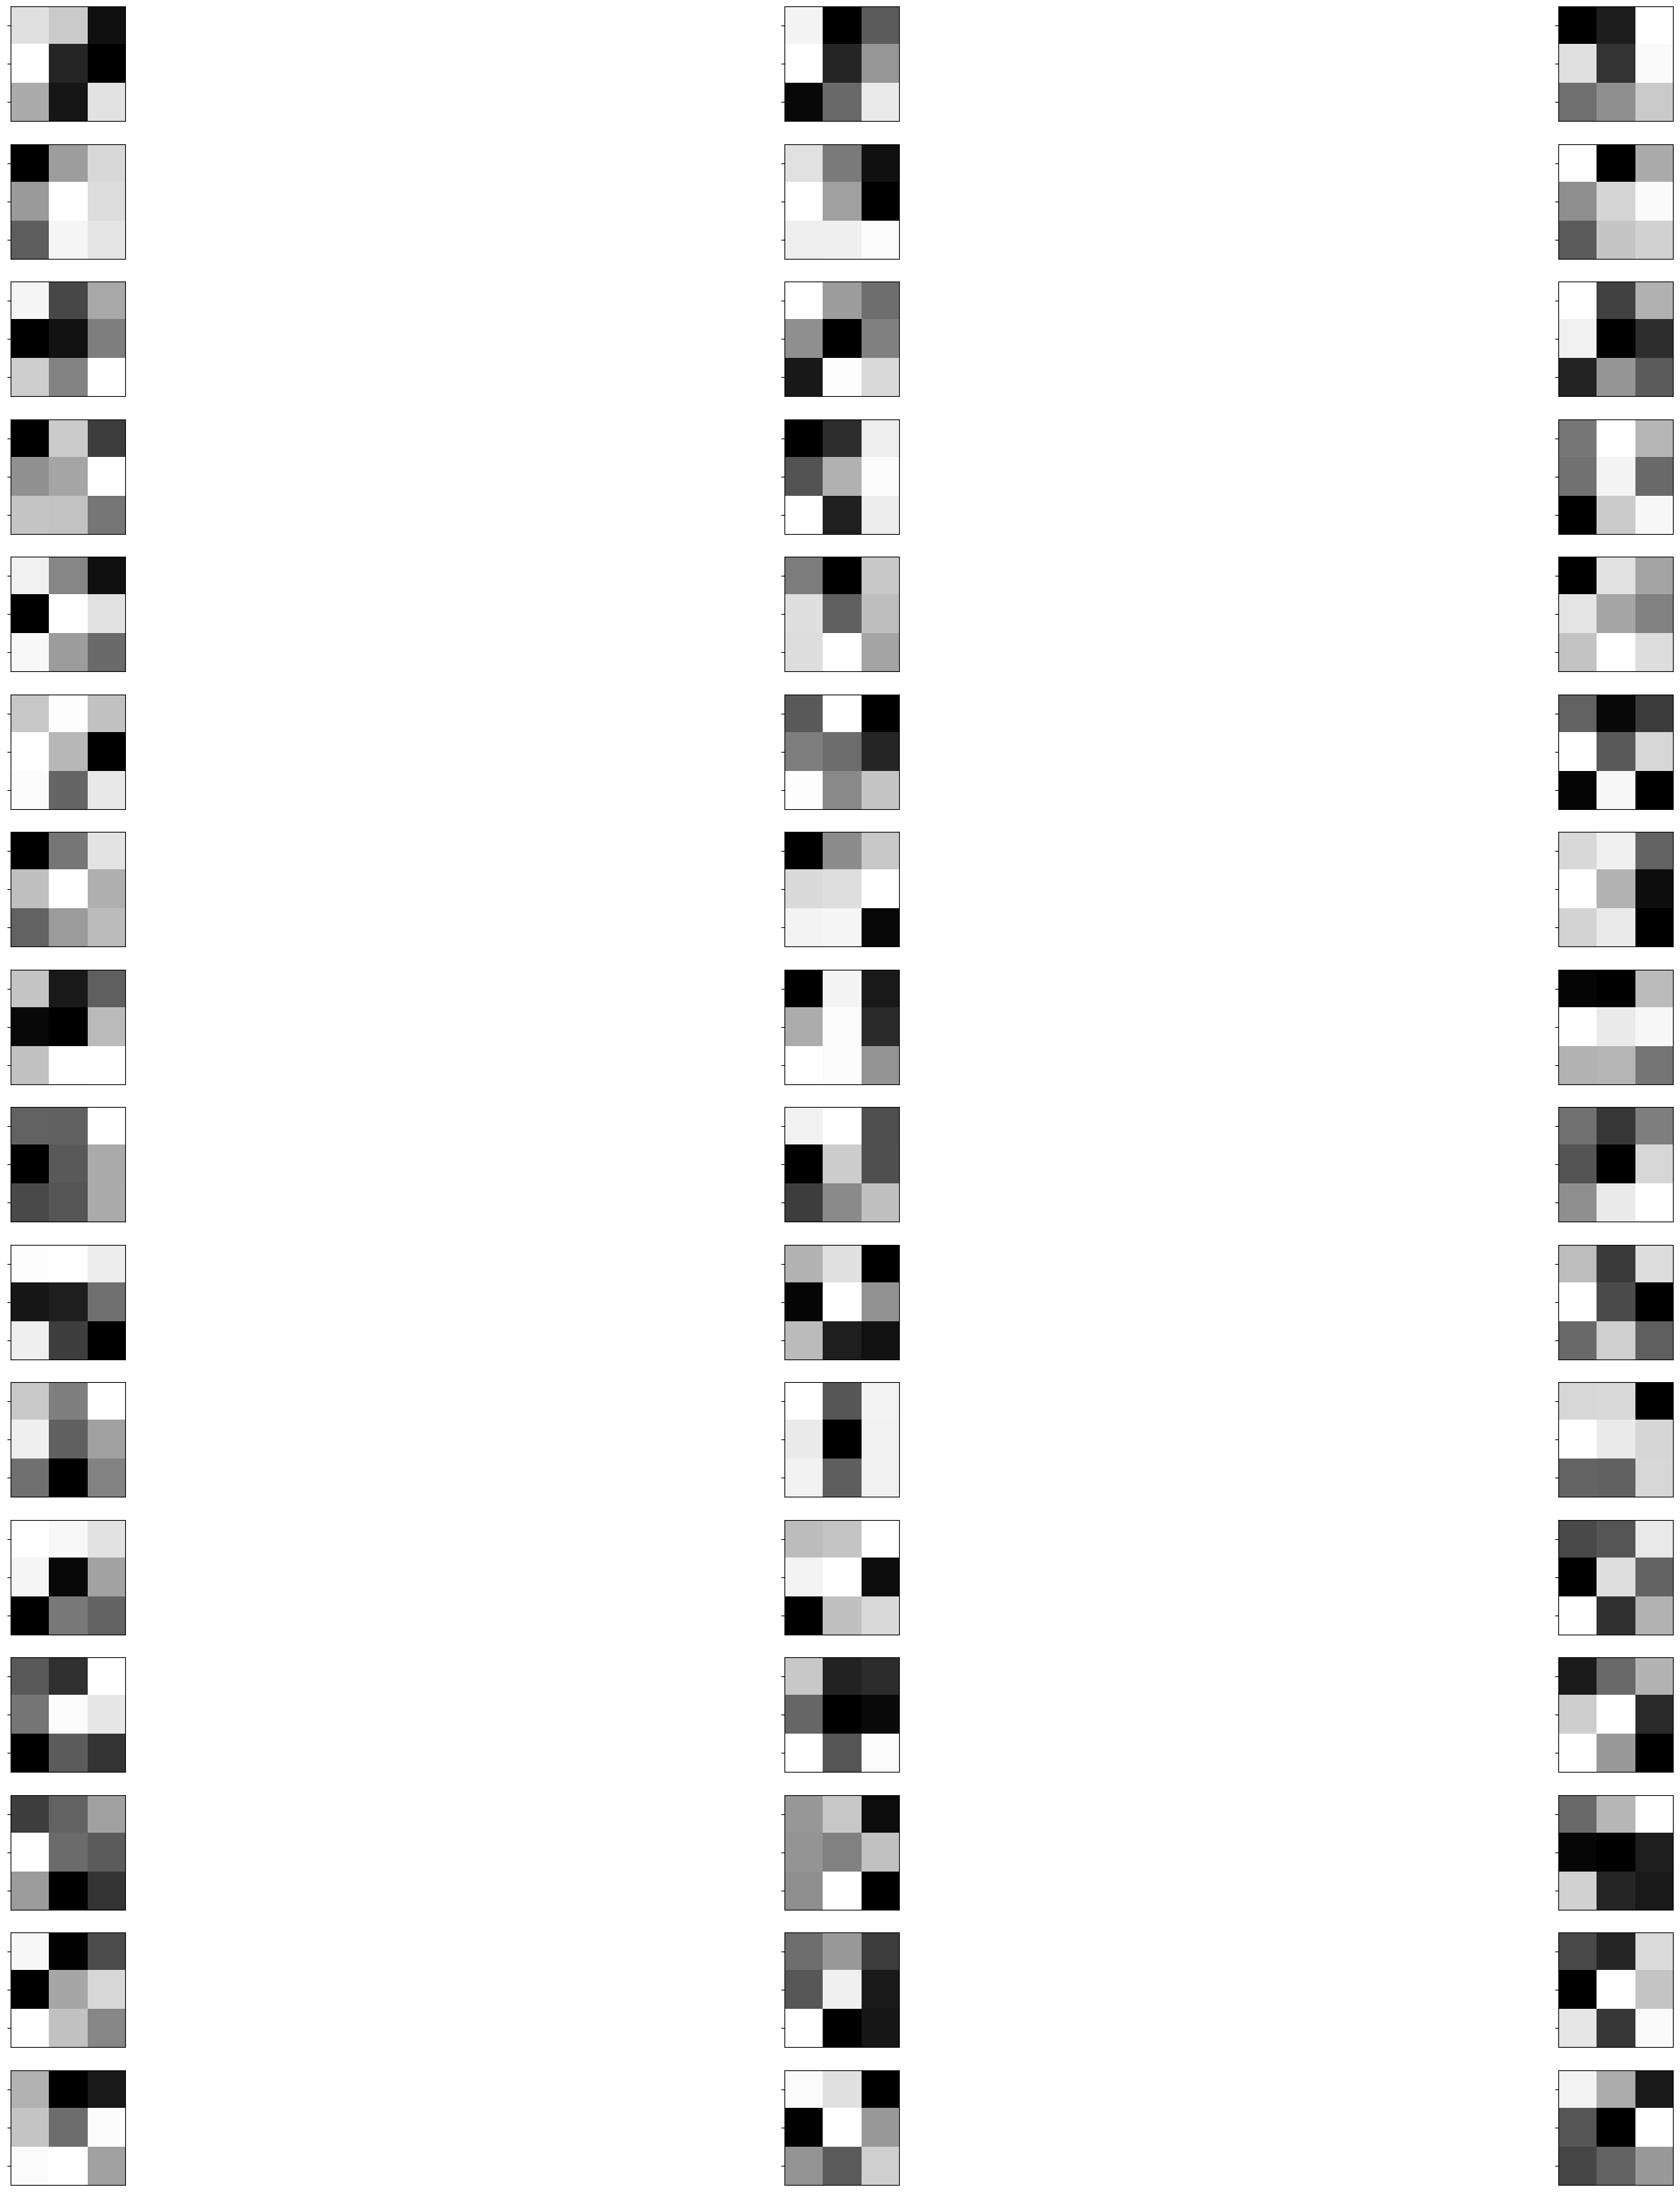

In [49]:
num_1 = conv2d_16_layer.kernel.shape[2]
num_2 = conv2d_16_layer.kernel.shape[3]

fig, ax = plt.subplots(num_2, num_1, figsize=(40,40))
for j in range(0, num_2):
    for i in range(0, num_1):
        filters_0 = conv2d_16_layer.kernel[:,:,i,j]
        ax[j,i].imshow(filters_0, cmap = 'Greys')
        ax[j,i].set_xticklabels([], fontsize = 0)
        ax[j,i].set_yticklabels([], fontsize = 0)
        ax[j,i].xaxis.set_ticks_position('none') 
        # plt.tick_params(
        # axis='x',          # changes apply to the x-axis
        # which='both',      # both major and minor ticks are affected
        # bottom=False,      # ticks along the bottom edge are off
        # top=False,         # ticks along the top edge are off
        # labelbottom=False) # labels along the bottom edge are off
plt.show()


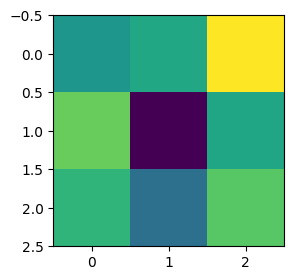

In [47]:
test_arr = filters_0
# print(test_arr.min(), test_arr.max())
# print(data_frame.iloc[random_sample_number]["Label"])
plt.figure(figsize=(3,3))
plt.imshow(filters_0)
plt.show()

In [41]:
plt.imshow(img[:,:,2])

NameError: name 'img' is not defined